# Mauna-Loa CO2 concentration example

Experiment of CO2 measurements in Mauna Loa, Hawaii, using a single output Gaussian process with a spectral mixture kernel. The data set contains daily measurements of CO2 in the air from 1958 to 2001. We will resample the data to obtain 10 averaged samples per year. That is, any yearly pattern will be at $\frac{1}{10} = 0.1$.

In [1]:
import mogptk
import numpy as np

In [2]:
from sklearn.datasets import fetch_openml

def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data['year']
    m = ml_data.data['month']
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs

First we load the dataset, and define a variable `stop` with the  index that separates between train and test

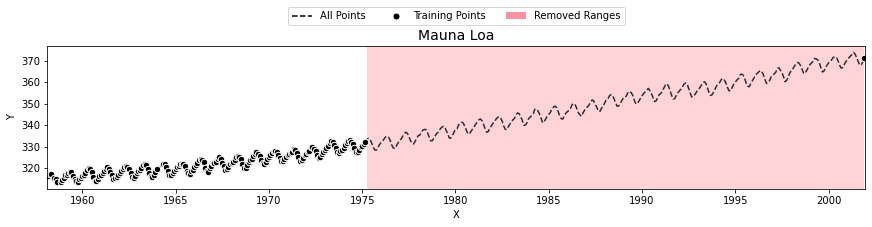

In [3]:
# load dataset
x, y = load_mauna_loa_atmospheric_co2()

# stop omde to separate train from test
stop = 200

data = mogptk.Data(x, y, name='Mauna Loa')
data.remove_range(start=x[stop])
data.transform(mogptk.TransformDetrend(3))
data.plot();

We initialize the model with random parameters and show the spectral density of the kernel. As we are only taking random values, there is no relation with the data.

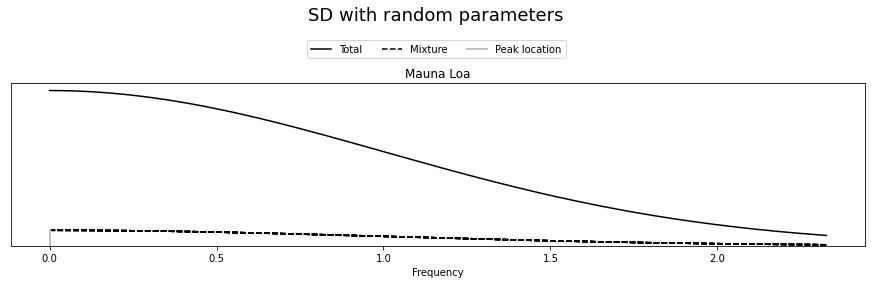

In [4]:
# create model
model = mogptk.SM(data, Q=10)
model.plot_spectrum(title='SD with random parameters');

Then we initialize the parameters before training, using Bayesian Nonparametric spectral estimation (BNSE) (Tobar 2017), and use the estimated Power spectral density (PSD) to define initial spectral mean and magnitudes.

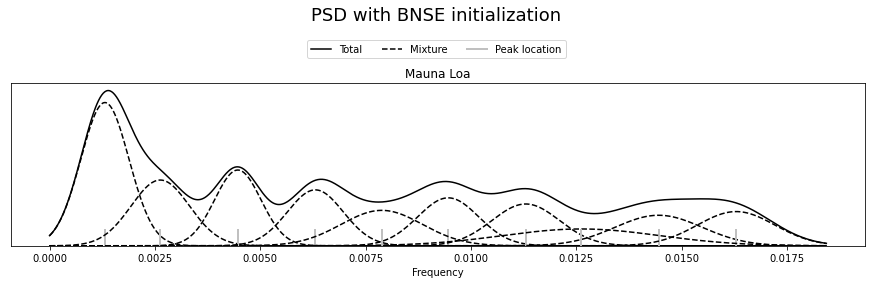

In [5]:
method = 'BNSE'
model.init_parameters(method)
model.plot_spectrum(title='PSD with {} initialization'.format(method));

Then we train the model and show the power spectral density of the trained model.

In [6]:
model.log_marginal_likelihood()

-322.4842724874515


Start Adam:
    0/1000  loss=   322.484  error=   1.88645
   10/1000  loss=   313.976  error=   1.88665
   20/1000  loss=   307.505  error=   1.88656
   30/1000  loss=   301.477  error=   1.88645
   40/1000  loss=   295.067  error=   1.88634
   50/1000  loss=   288.609  error=   1.88603
   60/1000  loss=   282.216  error=   1.88578
   70/1000  loss=   275.716  error=   1.88539
   80/1000  loss=   269.194  error=   1.88506
   90/1000  loss=   262.687  error=   1.88457
  100/1000  loss=   256.224  error=   1.88398
  110/1000  loss=   249.696  error=   1.88341
  120/1000  loss=   243.088  error=   1.88278
  130/1000  loss=   236.521  error=   1.88209
  140/1000  loss=   230.029  error=   1.88124
  150/1000  loss=   223.463  error=   1.88004
  160/1000  loss=   216.782  error=   1.87871
  170/1000  loss=   209.974  error=   1.87675
  180/1000  loss=   203.112  error=   1.87421
  190/1000  loss=   196.303  error=   1.87109
  200/1000  loss=   189.686  error=   1.86688
  210/1000  loss=   1

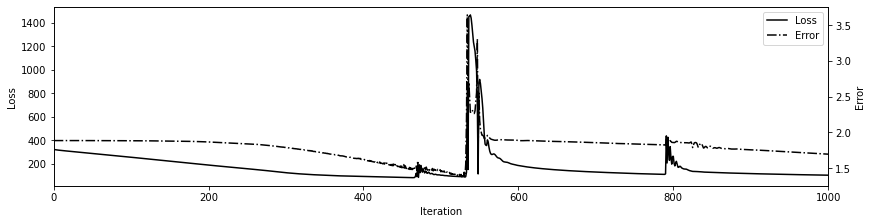

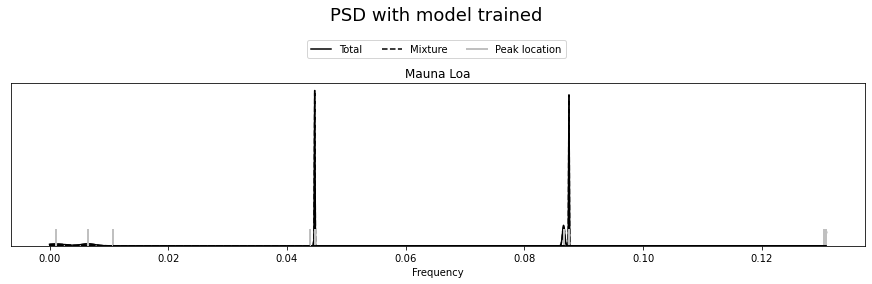

In [7]:
model.train(method='Adam', iters=1000, lr=0.1, plot=True, error='MAE')
model.plot_spectrum(title='PSD with model trained');

Lastly we predict in the test set.

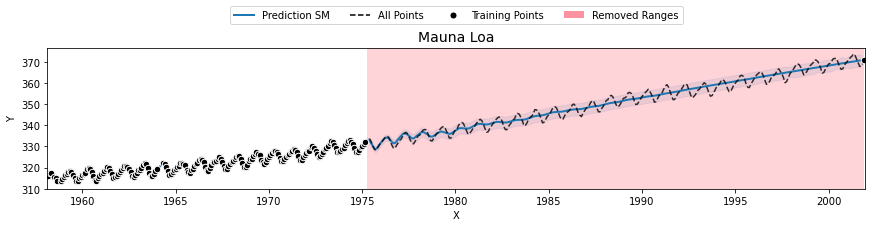

In [8]:
model.predict()
data.plot();